In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb

In [2]:
train = pd.read_csv('train.csv', index_col=0, parse_dates=[0])
store = pd.read_csv('store.csv')

/Users/admin/anaconda3/envs/dsr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#jak's function of taking care of missing values
def na_fixer(df):
    for column in df.columns:
        if df.dtypes[column]==object:
            df[column].fillna("Empty",inplace=True)
        else: df[column].fillna(0,inplace=True)
            
na_fixer(train)

In [4]:
train.loc[train['StateHoliday'] == 'a','StateHoliday'] = 1
train.loc[train['StateHoliday'] == 'b','StateHoliday'] = 2
train.loc[train['StateHoliday'] == 'c','StateHoliday'] = 3
train.loc[train['StateHoliday'] == 'Empty','StateHoliday'] = 4
train.loc[train['StateHoliday'] == 0.0,'StateHoliday'] = 5
train.loc[train['StateHoliday'] == '0','StateHoliday'] = 5

In [5]:
train['StateHoliday'].value_counts()

5    599227
4     19254
1     12798
2      4335
3      2160
Name: StateHoliday, dtype: int64

In [6]:
train.StateHoliday = train.StateHoliday.astype(float)

In [7]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

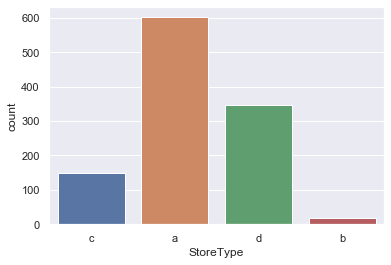

In [8]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="StoreType", data=store)

store.StoreType.value_counts()

In [9]:
train.dtypes

Store            float64
DayOfWeek        float64
Sales            float64
Customers        float64
Open             float64
Promo            float64
StateHoliday     float64
SchoolHoliday    float64
dtype: object

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_validate

In [11]:
#Take a percentage of the Data

train = train[:int(np.floor(0.05 * train.shape[0]))]

In [12]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
2013-01-01,376.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0


In [13]:
#from datetime import datetime

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return df

train = create_features(train)

In [14]:
train.shape

(31888, 17)

In [15]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,,,
2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2013-01-01,0,1,1,1,2013,1,1,1
2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2013-01-01,0,1,1,1,2013,1,1,1
2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2013-01-01,0,1,1,1,2013,1,1,1
2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2013-01-01,0,1,1,1,2013,1,1,1
2013-01-01,376.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2013-01-01,0,1,1,1,2013,1,1,1


In [20]:
train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'date', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [21]:
#specify X and y

#Here I drop all date and time variables.
X = train.drop(['Sales','DayOfWeek', 'date', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear'],axis=1)
y = train['Sales']

In [22]:
#Train,test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [23]:
#Initialize Random Forest
rf = RandomForestClassifier(n_estimators=5, max_depth=25,random_state=1)

rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [24]:
predict_val_2 = rf.predict(X_test)
mean_squared_error(y_test,predict_val_2)

5423611.374098464

In [ ]:
#gradient Boosted Trees

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=5,max_depth=25,random_state=1)

In [25]:
#I am not developing the XgBoost any better. Jak is doing that